In [6]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

from lib.algorithms_unconstrained import gradient_descent, nesterov, multi_step_gradient, triple_momentum, heavy_ball
# from lib.tracking_analysis import bisection_thm1, bisection_thm2
import lib.tracking_analysis as ta
from lib.utils import consistent_polytope_nd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# Plot settings
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

## Run Algorithms on an objective to test tracking bound

In [8]:
# obj = objectives.PeriodicExample2D(omega=0.1)
# # x = np.zeros(2)
# x = [0.1, 0.1]  # Initial point
# x = [0, 0]  # Initial point
# gaps = []

# for t in tqdm(range(10000)):
#     obj.update(t)
#     # Run gradient descent
#     x_star, m, L = obj.get_objective_info()
#     x = x - (1.0/max(L,1e-6)) * obj.gradient(x)
#     gaps.append(obj.eval(x))

## Comparison of algorithms for fixed $\overline{\nu}$

In [ ]:
L_range = np.logspace(np.log10(1/0.8 + 1e-3), 2, 10)

rhos_ogd, rhos_nag, rhos_tmm = [], [], []

n_grid = 2

for L in tqdm(L_range):

    ### Create consistent polytope grid over parameters
    L_min, L_max = L * 0.8, L
    grid_step = (L_max - L_min) / n_grid

    params = np.linspace(L_min, L_max, n_grid + 1)
    delta_L_max = lambda rate_bound: rate_bound * (L_max - L_min)

    grid_points = consistent_polytope_nd(params, -delta_L_max(rate_bound=0.05), delta_L_max(rate_bound=0.05), step_size=grid_step)

    ### Solve Bisection for every algorithm
    rho, sol = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points, optimize_sensitivities=True)
    rhos_ogd.append((rho, sol))

    rho, sol = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points, optimize_sensitivities=True)
    rhos_nag.append((rho, sol))

    rho, sol = ta.bisection_thm2(algo=triple_momentum, consistent_polytope=grid_points, optimize_sensitivities=True)
    rhos_tmm.append((rho, sol))


100%|██████████| 10/10 [00:00<00:00, 2341.22it/s]

Grid Points: [(array([1.0008]), array([0.])), (array([1.0008]), array([0.01251])), (array([1.1259]), array([-0.01251])), (array([1.1259]), array([0.01251])), (array([1.251]), array([-0.01251])), (array([1.251]), array([0.]))]
Grid Points: [(array([1.62840771]), array([0.])), (array([1.62840771]), array([0.0203551])), (array([1.83195868]), array([-0.0203551])), (array([1.83195868]), array([0.0203551])), (array([2.03550964]), array([-0.0203551])), (array([2.03550964]), array([0.]))]
Grid Points: [(array([2.64959201]), array([0.])), (array([2.64959201]), array([0.0331199])), (array([2.98079101]), array([-0.0331199])), (array([2.98079101]), array([0.0331199])), (array([3.31199001]), array([-0.0331199])), (array([3.31199001]), array([0.]))]
Grid Points: [(array([4.31116714]), array([0.])), (array([4.31116714]), array([0.05388959])), (array([4.85006303]), array([-0.05388959])), (array([4.85006303]), array([0.05388959])), (array([5.38895892]), array([-0.05388959])), (array([5.38895892]), arra

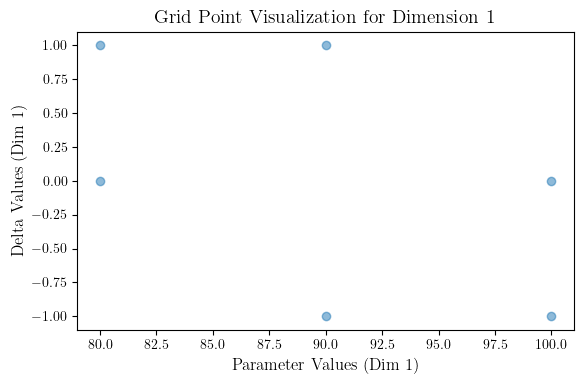

[(array([80.]), array([0.])),
 (array([80.]), array([1.])),
 (array([90.]), array([-1.])),
 (array([90.]), array([1.])),
 (array([100.]), array([-1.])),
 (array([100.]), array([0.]))]

In [11]:
rhos_ogd
for rho, sol in rhos_ogd:
    print(f"OGD: rho = {rho}, sol = {sol}")
# run_simulation(sol, algo=nesterov, obj=obj, x0=[0.1, 0.1], T=1000)
def visualize(grid_points, param_dim: int = None):
        """
        Visualizes the grid points in scatter plots.
        """

        p_values = np.array([p_k for p_k, _ in grid_points])
        delta_values = np.array([delta_p for _, delta_p in grid_points])
        num_dims = p_values.shape[1]  # Number of dimensions

        if param_dim is not None:
            if param_dim >= num_dims or param_dim < 0:
                print(f"Invalid dimension for visualization: {param_dim}")
                return

            # Single dimension plot
            plt.figure(figsize=(6, 4))
            plt.scatter(p_values[:, param_dim], delta_values[:, param_dim], alpha=0.5, label=f"Delta Values (Dim {param_dim+1})")
            plt.xlabel(f"Parameter Values (Dim {param_dim+1})")
            plt.ylabel(f"Delta Values (Dim {param_dim+1})")
            plt.title(f"Grid Point Visualization for Dimension {param_dim+1}")
            plt.show()
        else:
            # Multiple subplots for all dimensions
            fig, axes = plt.subplots(num_dims, 1, figsize=(6, 4 * num_dims))
            if num_dims == 1:
                axes = [axes]  # Ensure axes is always iterable

            for dim in range(num_dims):
                ax = axes[dim]
                ax.scatter(p_values[:, dim], delta_values[:, dim], alpha=0.5, label=f"Dim {dim}")
                ax.set_xlabel(f"Parameter Values (Dim {dim+1})")
                ax.set_ylabel(f"Delta Values (Dim {dim+1})")
                ax.set_title(f"Grid Point Visualization for Dimension {dim+1}")

            plt.tight_layout()
            plt.show()
visualize(grid_points=grid_points)
grid_points

### Plot of decay rate $\rho$

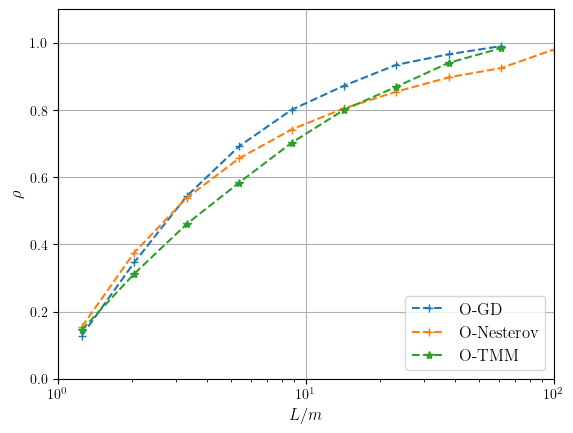

In [43]:
### Extract quantities to plot
# rhos_ogd_, rhos_nag_, rhos_ogd2_, rhos_ogd3_, rhos_ogd4_, rhos_ogd5_, rhos_tmm_ = map(lambda x: np.array([rho for rho, _ in x]), [rhos_ogd, rhos_nag, rhos_ogd2, rhos_ogd3, rhos_ogd4, rhos_ogd5, rhos_agd])
rhos_ogd_, rhos_nag_, rhos_tmm_ = map(lambda x: np.array([rho for rho, _ in x]), [rhos_ogd, rhos_nag, rhos_tmm])
tableau10 = plt.get_cmap('tab10').colors

### Plot results
plt.semilogx(L_range[rhos_ogd_ <= 1], rhos_ogd_[rhos_ogd_ <= 1], '--+', label=r'O-GD', color=tableau10[0])
plt.semilogx(L_range[rhos_nag_ <= 1], rhos_nag_[rhos_nag_ <= 1], '--+', label=r'O-Nesterov', color=tableau10[1])
plt.semilogx(L_range[rhos_tmm_ <= 1], rhos_tmm_[rhos_tmm_ <= 1], '--*', label=r'O-TMM', color=tableau10[2])

plt.xlabel(r'$L/m$')
plt.ylabel(r'$\rho$')

plt.xlim([1,100])
plt.ylim([0,1.1])

plt.legend(loc='lower right')
plt.grid()
plt.show()


### Plot of sensitivities

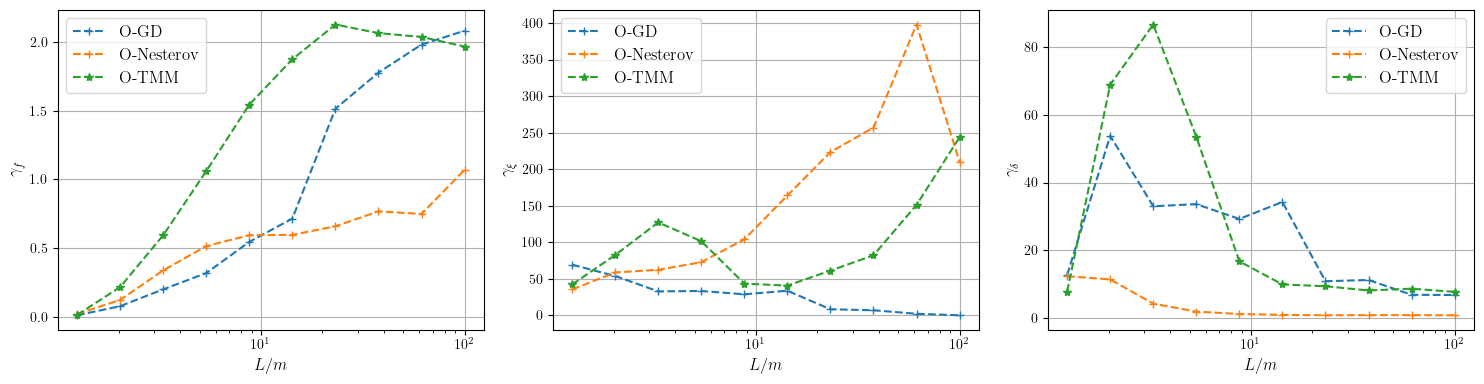

In [52]:

# Extract lambdas
lambdas_ogd_ = np.array([sol[1] for _, sol in rhos_ogd]).flatten() * (L_range-1) * rhos_ogd_**2
lambdas_nag_ = np.array([sol[1] for _, sol in rhos_nag]).flatten() * (L_range-1) * rhos_ogd_**2
lambdas_tmm_ = np.array([sol[1] for _, sol in rhos_tmm]).flatten() * (L_range-1) * rhos_ogd_**2

# Extract gamma_x
gamma_x_ogd_ = np.array([sol[2] for _, sol in rhos_ogd])
gamma_x_nag_ = np.array([sol[2] for _, sol in rhos_nag])
gamma_x_tmm_ = np.array([sol[2] for _, sol in rhos_tmm])

# Extract gamma_d
gamma_d_ogd_ = np.array([sol[3] for _, sol in rhos_ogd])
gamma_d_nag_ = np.array([sol[3] for _, sol in rhos_nag])
gamma_d_tmm_ = np.array([sol[3] for _, sol in rhos_tmm])

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
tableau10 = plt.get_cmap('tab10').colors

# First subplot: lambdas
axes[0].semilogx(L_range, lambdas_ogd_, '--+', label=r'O-GD',       color=tableau10[0])
axes[0].semilogx(L_range, lambdas_nag_, '--+', label=r'O-Nesterov', color=tableau10[1])
axes[0].semilogx(L_range, lambdas_tmm_, '--*', label=r'O-TMM',      color=tableau10[2])
axes[0].set_xlabel(r'$L/m$')
axes[0].set_ylabel(r'$\gamma_f$')
axes[0].grid()
axes[0].legend()

# Second subplot: gamma_x
axes[1].semilogx(L_range, gamma_x_ogd_, '--+', label=r'O-GD',       color=tableau10[0])
axes[1].semilogx(L_range, gamma_x_nag_, '--+', label=r'O-Nesterov', color=tableau10[1])
axes[1].semilogx(L_range, gamma_x_tmm_, '--*', label=r'O-TMM',      color=tableau10[2])
axes[1].set_xlabel(r'$L/m$')
axes[1].set_ylabel(r'$\gamma_{\xi}$')
axes[1].grid()
axes[1].legend()

# Third subplot: gamma_d
axes[2].semilogx(L_range, gamma_d_ogd_, '--+', label=r'O-GD',       color=tableau10[0])
axes[2].semilogx(L_range, gamma_d_nag_, '--+', label=r'O-Nesterov', color=tableau10[1])
axes[2].semilogx(L_range, gamma_d_tmm_, '--*', label=r'O-TMM',      color=tableau10[2])
axes[2].set_xlabel(r'$L/m$')
axes[2].set_ylabel(r'$\gamma_\delta$')
axes[2].grid()
axes[2].legend()

plt.tight_layout()
plt.show()

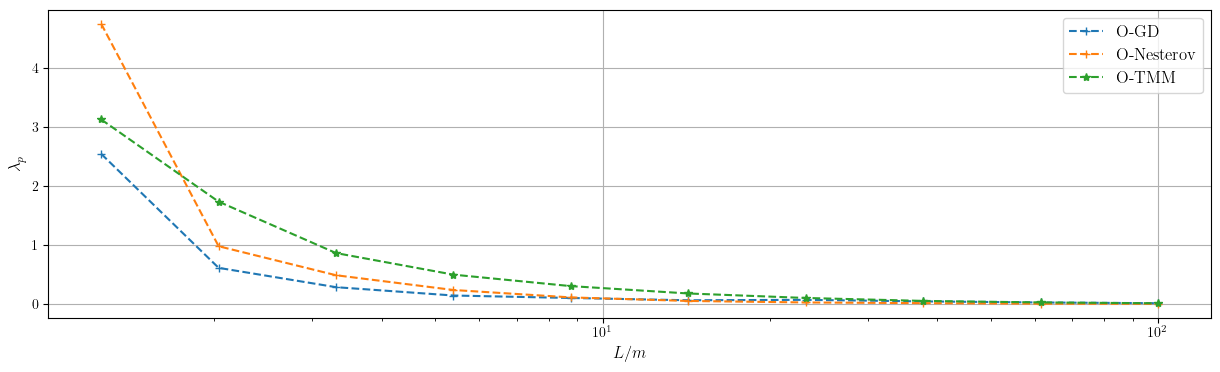

In [73]:
fig, axes = plt.subplots(1, 1, figsize=(15, 4), sharex=True)
tableau10 = plt.get_cmap('tab10').colors

# First subplot: lambdas
axes.semilogx(L_range, np.array([sol[1] for _, sol in rhos_ogd]).flatten(), '--+', label=r'O-GD',       color=tableau10[0])
axes.semilogx(L_range, np.array([sol[1] for _, sol in rhos_nag]).flatten(), '--+', label=r'O-Nesterov', color=tableau10[1])
axes.semilogx(L_range, np.array([sol[1] for _, sol in rhos_tmm]).flatten(), '--*', label=r'O-TMM',      color=tableau10[2])
axes.set_xlabel(r'$L/m$')
axes.set_ylabel(r'$\lambda_p$')
axes.grid()
axes.legend()

## Comparison of rates for different $\overline{\nu}$

In [ ]:
L_range = np.logspace(np.log10(1/0.8 + 1e-3), 2, 10)

rhos_fast_gd, rhos_middle_gd, rhos_slow_gd, rho_nom_gd = (list() for _ in range(4))
rhos_fast_nag, rhos_middle_nag, rhos_slow_nag, rho_nom_nag = (list() for _ in range(4))

n_sparse = 3

for L in tqdm(L_range):

    ### Create consistent polytope grid over parameters
    L_min, L_max = L * 0.8, L
    grid_step = (L_max - L_min) / n_sparse

    params = np.linspace(L_min, L_max, n_sparse + 1)
    delta_L_max = lambda rate_bound: rate_bound * (L_max - L_min)

    grid_points_fast = consistent_polytope_nd(params, -delta_L_max(rate_bound=1), delta_L_max(rate_bound=1), step_size=grid_step)
    grid_points_mod  = consistent_polytope_nd(params, -delta_L_max(rate_bound=0.5), delta_L_max(rate_bound=0.5), step_size=grid_step)
    grid_points_slow = consistent_polytope_nd(params, -delta_L_max(rate_bound=0.05), delta_L_max(rate_bound=0.05), step_size=grid_step)
    grid_static = [(np.array([L]), np.array([0]))]

    ### fast parameter variations
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points_fast, optimize_sensitivities=False)
    rhos_fast_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points_fast, optimize_sensitivities=False)
    rhos_fast_nag.append(rho)

    ### moderate parameter variations
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points_mod, optimize_sensitivities=False)
    rhos_middle_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points_mod, optimize_sensitivities=False)
    rhos_middle_nag.append(rho)

    ### slow parameter variations
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_points_slow, optimize_sensitivities=False)
    rhos_slow_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_points_slow, optimize_sensitivities=False)
    rhos_slow_nag.append(rho)

    ### static
    rho, _ = ta.bisection_thm2(algo=gradient_descent, consistent_polytope=grid_static, optimize_sensitivities=False)
    rho_nom_gd.append(rho)
    rho, _ = ta.bisection_thm2(algo=nesterov, consistent_polytope=grid_static, optimize_sensitivities=False)
    rho_nom_nag.append(rho)

In [ ]:
### Extract quantities to plot
# L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd = map(np.array, [L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd])
L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd, rhos_slow_gd = map(np.array, [L_range, rho_nom_gd, rhos_fast_gd, rhos_middle_gd, rhos_slow_gd])
# rho_nom_nag, rhos_fast_nag, rhos_middle_nag = map(np.array, [rho_nom_nag, rhos_fast_nag, rhos_middle_nag])
rho_nom_nag, rhos_fast_nag, rhos_middle_nag, rhos_slow_nag = map(np.array, [rho_nom_nag, rhos_fast_nag, rhos_middle_nag, rhos_slow_nag])

NameError: name 'rhos_fast_gd' is not defined

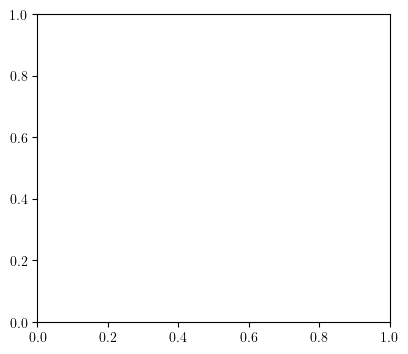

In [46]:
tableau10 = plt.get_cmap('tab10').colors

### Plot results
plt.figure(figsize=(10,4))

# Gradient Descent
plt.subplot(1,2,1)
plt.semilogx(L_range[rhos_fast_gd <= 1],   rhos_fast_gd[rhos_fast_gd <= 1],     '--+', label=r'Fast variation ($\overline{\nu} = \nu_{\max}$)',      color=tableau10[0])
plt.semilogx(L_range[rhos_middle_gd <= 1], rhos_middle_gd[rhos_middle_gd <= 1], '--+', label=r'Mod. variation ($\overline{\nu} = 0.5\nu_{\max}$)',   color=tableau10[1])
plt.semilogx(L_range[rhos_slow_gd <= 1],   rhos_slow_gd[rhos_slow_gd <= 1],     '--*', label=r'Slow variation ($\overline{\nu} = 0.05\nu_{\max}$)',  color=tableau10[2])
plt.semilogx(L_range[rho_nom_gd <= 1],     rho_nom_gd[rho_nom_gd <= 1],         '--*', label=r'Nominal',                                            color=tableau10[3])

plt.xlabel(r'$L/m$')
plt.ylabel(r'$\rho$')
plt.xlim([1, 100])
plt.ylim([0, 1.1])
plt.legend(loc='lower right')
plt.grid()
plt.title('Gradient descent')

# Nesterov
plt.subplot(1,2,2)
plt.semilogx(L_range[rhos_fast_nag <= 1],   rhos_fast_nag[rhos_fast_nag <= 1],     '--+', label=r'Fast variation ($\overline{\nu} = \nu_{\max}$)',      color=tableau10[0])
plt.semilogx(L_range[rhos_middle_nag <= 1], rhos_middle_nag[rhos_middle_nag <= 1], '--+', label=r'Mod. variation ($\overline{\nu} = 0.5\nu_{\max}$)',   color=tableau10[1])
plt.semilogx(L_range[rhos_slow_nag <= 1],   rhos_slow_nag[rhos_slow_nag <= 1],     '--*', label=r'Slow variation ($\overline{\nu} = 0.05\nu_{\max}$)',  color=tableau10[2])
plt.semilogx(L_range[rho_nom_nag <= 1],     rho_nom_nag[rho_nom_nag <= 1],         '--*', label=r'Nominal',                                            color=tableau10[3])

plt.xlabel(r'$L/m$')
plt.ylabel(r'$\rho$')
plt.xlim([1, 100])
plt.ylim([0, 1.1])
plt.legend(loc='lower right')
plt.grid()
plt.title('Nesterov')

plt.show()
